## _*Quantum SVM algorithm:  multiclass classifier extension*_

A multiclass extension works in conjunction with an underlying binary (two class) classifier to provide multiclass classification.

Currently three different multiclass extensions are supported:

* OneAgainstRest
* AllPairs
* ErrorCorrectingCode

These use different techniques to group the data with binary classification to achieve the final multiclass classification.

In [1]:
import numpy as np
from qiskit.ml.datasets import wine
from qiskit import BasicAer
from qiskit.aqua.input import ClassificationInput
from qiskit.aqua import run_algorithm

Here we choose the `Wine` dataset which has 3 classes.

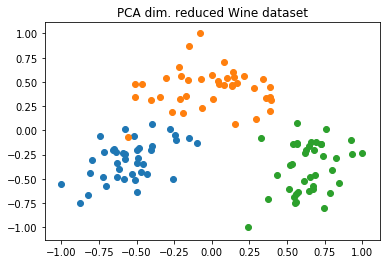

In [2]:
n = 2  # dimension of each data point
sample_Total, training_input, test_input, class_labels = wine(
    training_size=40,
    test_size=10, n=n, plot_data=True
)
temp = [test_input[k] for k in test_input]
total_array = np.concatenate(temp)

Now we setup an Aqua configuration dictionary to use the quantum `QSVM` algorithm and add a multiclass extension to classify the Wine data set, since it has 3 classes.

Although the `AllPairs` extension is used here in the example the following multiclass extensions would also work:

    'multiclass_extension': {'name': 'OneAgainstRest'}
    'multiclass_extension': {'name': 'ErrorCorrectingCode', 'code_size': 5}

In [3]:
aqua_dict = {
    'problem': {'name': 'classification', 'random_seed': 10598},
    'algorithm': {
        'name': 'QSVM'
    },
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2, 'entangler_map': [[0, 1]]},
    'multiclass_extension': {'name': 'AllPairs'},
    'backend': {'shots': 1024}
}

backend = BasicAer.get_backend('qasm_simulator')
algo_input = ClassificationInput(training_input, test_input, total_array)
result = run_algorithm(aqua_dict, algo_input, backend=backend)
for k,v in result.items():
    print("'{}' : {}".format(k, v))


'testing_accuracy' : 0.9
'test_success_ratio' : 0.9
'predicted_labels' : [0 0 1 1 1 2 2 0 2 2]
'predicted_classes' : ['A', 'A', 'B', 'B', 'B', 'C', 'C', 'A', 'C', 'C']
